# Depth estimator for kitti

> Depth estimator


- skip_showdoc: true
- skip_exec: true

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets, utils
import urllib.request
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas = midas.eval()


In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")


Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

transform

Compose(
    <function transforms.<locals>.<lambda>>
    <midas.transforms.Resize object>
    <midas.transforms.NormalizeImage object>
    <midas.transforms.PrepareForNet object>
    <function transforms.<locals>.<lambda>>
)

## Getting Images

In [ ]:
from PIL import Image
from torchvision.transforms import ToPILImage

In [ ]:
from torchvision import transforms

# Define transforms to apply to the images
transform_default = transforms.Compose([
    transforms.Resize((200, 300)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # Add more transformations as needed (e.g., normalization)
])

# Path to the root directory of the dataset
root_dir = 'Data'

# Create datasets
train_dataset = datasets.Country211(root_dir,
                                   split = 'train',
                                    transform=transform_default,
                                    download = False)
val_dataset = datasets.Country211(root_dir,
                                   split = 'valid',
                                    transform=transform_default,
                                    download = False)
test_dataset = datasets.Country211(root_dir,
                                   split = 'test',
                                    transform=transform_default,
                                    download = False)

In [ ]:
filename, label = train_dataset.imgs[0]
filename

'Data/country211/train/AD/1209731_42.51083_1.693096.jpg'

In [ ]:
folder = filename.rsplit('/', 5)
folder

['Data', 'country211', 'train', 'AD', '1209731_42.51083_1.693096.jpg']

In [ ]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<matplotlib.image.AxesImage>

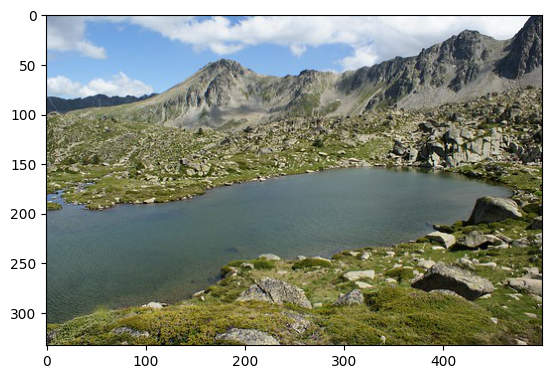

In [ ]:
plt.imshow(img)

In [ ]:
input_batch = transform(img).to(device)
input_batch.shape

torch.Size([1, 3, 384, 576])

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
img_range = (torch.max(prediction) - torch.min(prediction))
prediction1 = ((prediction - torch.min(prediction)) / img_range) * 255
prediction1 = prediction1.round().to(torch.uint8)
output = prediction1.cpu().numpy()

(-0.5, 499.5, 332.5, -0.5)

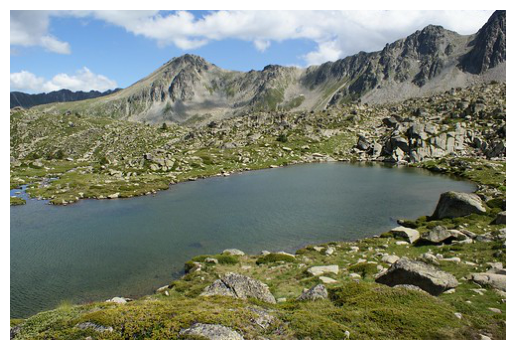

In [ ]:
plt.imshow(img)
plt.axis("off")

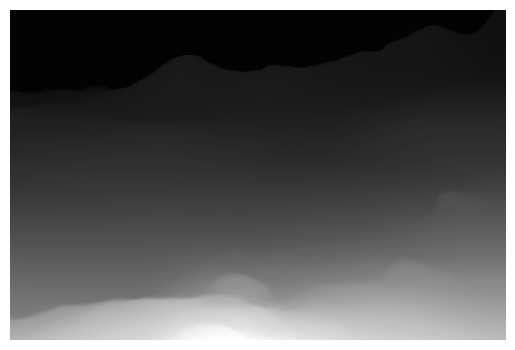

In [ ]:
plt.imshow(output, cmap='gray')
plt.axis("off")
plt.show()

## Resave Coountry211 as RGB_D

In [ ]:
import os

def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")

def resave_images(transformed_dataset):
    filename, label = transformed_dataset
    folder = filename.rsplit('/', 4)
    
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    input_batch = transform(img).to(device)
    input_batch.shape
    
    with torch.no_grad():
        prediction = midas(input_batch)
    
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    
    img_range = (torch.max(prediction) - torch.min(prediction))
    prediction1 = ((prediction - torch.min(prediction)) / img_range) * 255
    prediction1 = prediction1.round().to(torch.uint8)
    output = prediction1.cpu()

    image_array = np.expand_dims(output.numpy(), axis=-1)
    # Combine the RGB array and the grayscale array along the channel axis
    combined_array = np.concatenate((img, image_array), axis=-1)
    combined_image = Image.fromarray(combined_array)

    folder_path = f'{folder[0]}/country211_depth/country211/{folder[2]}/{folder[3]}'
    create_folder_if_not_exists(folder_path)

    name = folder[-1].rsplit('.', 1)

    combined_image.save(f'{folder_path}/{name[0]}.png')
    return combined_image, folder_path

In [ ]:
combined_image, folder_path = resave_images(train_dataset.imgs[0])

In [ ]:
len(train_dataset.imgs)

31650

In [ ]:
for train_data in tqdm(train_dataset.imgs):
    combined_image, folder_path = resave_images(train_data)

  0%|▎                                                                            | 151/31650 [00:41<2:20:47,  3.73it/s]

Folder 'Data/country211_depth/country211/train/AE' created.


  1%|▋                                                                            | 301/31650 [01:23<2:31:50,  3.44it/s]

Folder 'Data/country211_depth/country211/train/AF' created.


  1%|█                                                                            | 451/31650 [02:06<2:23:06,  3.63it/s]

Folder 'Data/country211_depth/country211/train/AG' created.


  2%|█▍                                                                           | 601/31650 [02:48<2:45:31,  3.13it/s]

Folder 'Data/country211_depth/country211/train/AI' created.


  2%|█▊                                                                           | 751/31650 [03:32<3:16:45,  2.62it/s]

Folder 'Data/country211_depth/country211/train/AL' created.


  3%|██▏                                                                          | 901/31650 [04:21<2:37:41,  3.25it/s]

Folder 'Data/country211_depth/country211/train/AM' created.


  3%|██▌                                                                         | 1051/31650 [05:08<2:24:08,  3.54it/s]

Folder 'Data/country211_depth/country211/train/AO' created.


  4%|██▉                                                                         | 1201/31650 [05:54<2:37:00,  3.23it/s]

Folder 'Data/country211_depth/country211/train/AQ' created.


  4%|███▏                                                                        | 1351/31650 [06:38<2:23:41,  3.51it/s]

Folder 'Data/country211_depth/country211/train/AR' created.


  5%|███▌                                                                        | 1501/31650 [07:23<2:34:23,  3.25it/s]

Folder 'Data/country211_depth/country211/train/AT' created.


  5%|███▉                                                                        | 1651/31650 [08:10<2:31:16,  3.31it/s]

Folder 'Data/country211_depth/country211/train/AU' created.


  6%|████▎                                                                       | 1801/31650 [08:56<2:37:54,  3.15it/s]

Folder 'Data/country211_depth/country211/train/AW' created.


  6%|████▋                                                                       | 1951/31650 [09:41<2:36:46,  3.16it/s]

Folder 'Data/country211_depth/country211/train/AX' created.


  7%|█████                                                                       | 2101/31650 [10:28<2:37:22,  3.13it/s]

Folder 'Data/country211_depth/country211/train/AZ' created.


  7%|█████▍                                                                      | 2251/31650 [11:12<2:26:15,  3.35it/s]

Folder 'Data/country211_depth/country211/train/BA' created.


  8%|█████▊                                                                      | 2401/31650 [11:56<2:28:59,  3.27it/s]

Folder 'Data/country211_depth/country211/train/BB' created.


  8%|██████▏                                                                     | 2551/31650 [12:40<2:26:28,  3.31it/s]

Folder 'Data/country211_depth/country211/train/BD' created.


  9%|██████▍                                                                     | 2701/31650 [13:23<2:14:20,  3.59it/s]

Folder 'Data/country211_depth/country211/train/BE' created.


  9%|██████▊                                                                     | 2851/31650 [14:09<2:30:58,  3.18it/s]

Folder 'Data/country211_depth/country211/train/BF' created.


  9%|███████▏                                                                    | 3001/31650 [14:54<2:27:54,  3.23it/s]

Folder 'Data/country211_depth/country211/train/BG' created.


 10%|███████▌                                                                    | 3151/31650 [15:39<2:31:15,  3.14it/s]

Folder 'Data/country211_depth/country211/train/BH' created.


 10%|███████▉                                                                    | 3301/31650 [16:25<2:16:10,  3.47it/s]

Folder 'Data/country211_depth/country211/train/BJ' created.


 11%|████████▎                                                                   | 3451/31650 [17:09<2:28:03,  3.17it/s]

Folder 'Data/country211_depth/country211/train/BM' created.


 11%|████████▋                                                                   | 3601/31650 [17:55<2:28:20,  3.15it/s]

Folder 'Data/country211_depth/country211/train/BN' created.


 12%|█████████                                                                   | 3751/31650 [18:40<2:26:20,  3.18it/s]

Folder 'Data/country211_depth/country211/train/BO' created.


 12%|█████████▎                                                                  | 3901/31650 [19:25<2:22:56,  3.24it/s]

Folder 'Data/country211_depth/country211/train/BQ' created.


 13%|█████████▋                                                                  | 4051/31650 [20:12<2:16:15,  3.38it/s]

Folder 'Data/country211_depth/country211/train/BR' created.


 13%|██████████                                                                  | 4201/31650 [20:57<2:30:11,  3.05it/s]

Folder 'Data/country211_depth/country211/train/BS' created.


 14%|██████████▍                                                                 | 4351/31650 [21:45<1:58:27,  3.84it/s]

Folder 'Data/country211_depth/country211/train/BT' created.


 14%|██████████▊                                                                 | 4501/31650 [22:32<2:15:46,  3.33it/s]

Folder 'Data/country211_depth/country211/train/BW' created.


 15%|███████████▏                                                                | 4651/31650 [23:17<2:14:28,  3.35it/s]

Folder 'Data/country211_depth/country211/train/BY' created.


 15%|███████████▌                                                                | 4801/31650 [24:04<2:19:13,  3.21it/s]

Folder 'Data/country211_depth/country211/train/BZ' created.


 16%|███████████▉                                                                | 4951/31650 [24:51<2:13:59,  3.32it/s]

Folder 'Data/country211_depth/country211/train/CA' created.


 16%|████████████▏                                                               | 5101/31650 [25:37<2:05:53,  3.51it/s]

Folder 'Data/country211_depth/country211/train/CD' created.


 17%|████████████▌                                                               | 5251/31650 [26:24<2:15:16,  3.25it/s]

Folder 'Data/country211_depth/country211/train/CF' created.


 17%|████████████▉                                                               | 5401/31650 [27:11<2:18:07,  3.17it/s]

Folder 'Data/country211_depth/country211/train/CH' created.


 18%|█████████████▎                                                              | 5551/31650 [27:59<1:53:25,  3.83it/s]

Folder 'Data/country211_depth/country211/train/CI' created.


 18%|█████████████▋                                                              | 5701/31650 [28:45<2:09:55,  3.33it/s]

Folder 'Data/country211_depth/country211/train/CK' created.


 18%|██████████████                                                              | 5851/31650 [29:31<2:14:35,  3.19it/s]

Folder 'Data/country211_depth/country211/train/CL' created.


 19%|██████████████▍                                                             | 6001/31650 [30:14<2:03:38,  3.46it/s]

Folder 'Data/country211_depth/country211/train/CM' created.


 19%|██████████████▊                                                             | 6151/31650 [30:58<2:12:30,  3.21it/s]

Folder 'Data/country211_depth/country211/train/CN' created.


 20%|███████████████▏                                                            | 6301/31650 [31:43<2:02:36,  3.45it/s]

Folder 'Data/country211_depth/country211/train/CO' created.


 20%|███████████████▍                                                            | 6451/31650 [32:27<1:54:30,  3.67it/s]

Folder 'Data/country211_depth/country211/train/CR' created.


 21%|███████████████▊                                                            | 6601/31650 [33:12<2:07:04,  3.29it/s]

Folder 'Data/country211_depth/country211/train/CU' created.


 21%|████████████████▏                                                           | 6751/31650 [33:58<2:04:52,  3.32it/s]

Folder 'Data/country211_depth/country211/train/CV' created.


 22%|████████████████▌                                                           | 6901/31650 [34:42<1:59:10,  3.46it/s]

Folder 'Data/country211_depth/country211/train/CW' created.


 22%|████████████████▉                                                           | 7051/31650 [35:26<2:10:27,  3.14it/s]

Folder 'Data/country211_depth/country211/train/CY' created.


 23%|█████████████████▎                                                          | 7201/31650 [36:13<1:56:38,  3.49it/s]

Folder 'Data/country211_depth/country211/train/CZ' created.


 23%|█████████████████▋                                                          | 7351/31650 [37:00<2:07:29,  3.18it/s]

Folder 'Data/country211_depth/country211/train/DE' created.


 24%|██████████████████                                                          | 7501/31650 [37:45<2:08:43,  3.13it/s]

Folder 'Data/country211_depth/country211/train/DK' created.


 24%|██████████████████▎                                                         | 7651/31650 [38:33<2:04:36,  3.21it/s]

Folder 'Data/country211_depth/country211/train/DM' created.


 25%|██████████████████▋                                                         | 7801/31650 [39:16<1:53:59,  3.49it/s]

Folder 'Data/country211_depth/country211/train/DO' created.


 25%|███████████████████                                                         | 7951/31650 [40:03<2:03:09,  3.21it/s]

Folder 'Data/country211_depth/country211/train/DZ' created.


 26%|███████████████████▍                                                        | 8101/31650 [40:47<1:56:08,  3.38it/s]

Folder 'Data/country211_depth/country211/train/EC' created.


 26%|███████████████████▊                                                        | 8251/31650 [41:33<2:00:21,  3.24it/s]

Folder 'Data/country211_depth/country211/train/EE' created.


 27%|████████████████████▏                                                       | 8401/31650 [42:18<1:57:23,  3.30it/s]

Folder 'Data/country211_depth/country211/train/EG' created.


 27%|████████████████████▌                                                       | 8551/31650 [43:04<2:04:36,  3.09it/s]

Folder 'Data/country211_depth/country211/train/ES' created.


 27%|████████████████████▉                                                       | 8701/31650 [43:53<2:04:17,  3.08it/s]

Folder 'Data/country211_depth/country211/train/ET' created.


 28%|█████████████████████▎                                                      | 8851/31650 [44:40<1:57:45,  3.23it/s]

Folder 'Data/country211_depth/country211/train/FI' created.


 28%|█████████████████████▌                                                      | 9001/31650 [45:25<1:59:40,  3.15it/s]

Folder 'Data/country211_depth/country211/train/FJ' created.


 29%|█████████████████████▉                                                      | 9151/31650 [46:10<1:58:21,  3.17it/s]

Folder 'Data/country211_depth/country211/train/FK' created.


 29%|██████████████████████▎                                                     | 9301/31650 [46:57<1:58:24,  3.15it/s]

Folder 'Data/country211_depth/country211/train/FO' created.


 30%|██████████████████████▋                                                     | 9451/31650 [47:44<2:00:42,  3.07it/s]

Folder 'Data/country211_depth/country211/train/FR' created.


 30%|███████████████████████                                                     | 9601/31650 [48:31<1:54:44,  3.20it/s]

Folder 'Data/country211_depth/country211/train/GA' created.


 31%|███████████████████████▍                                                    | 9751/31650 [49:19<2:04:35,  2.93it/s]

Folder 'Data/country211_depth/country211/train/GB' created.


 31%|███████████████████████▊                                                    | 9901/31650 [50:05<1:52:57,  3.21it/s]

Folder 'Data/country211_depth/country211/train/GD' created.


 32%|███████████████████████▊                                                   | 10051/31650 [50:51<1:40:58,  3.57it/s]

Folder 'Data/country211_depth/country211/train/GE' created.


 32%|████████████████████████▏                                                  | 10201/31650 [51:39<2:04:54,  2.86it/s]

Folder 'Data/country211_depth/country211/train/GF' created.


 33%|████████████████████████▌                                                  | 10351/31650 [52:26<1:55:56,  3.06it/s]

Folder 'Data/country211_depth/country211/train/GG' created.


 33%|████████████████████████▉                                                  | 10501/31650 [53:11<1:18:52,  4.47it/s]

Folder 'Data/country211_depth/country211/train/GH' created.


 34%|█████████████████████████▏                                                 | 10651/31650 [53:58<1:30:32,  3.87it/s]

Folder 'Data/country211_depth/country211/train/GI' created.


 34%|█████████████████████████▌                                                 | 10801/31650 [54:41<1:44:35,  3.32it/s]

Folder 'Data/country211_depth/country211/train/GL' created.


 35%|█████████████████████████▉                                                 | 10951/31650 [55:26<1:45:39,  3.27it/s]

Folder 'Data/country211_depth/country211/train/GM' created.


 35%|██████████████████████████▎                                                | 11101/31650 [56:14<1:58:19,  2.89it/s]

Folder 'Data/country211_depth/country211/train/GP' created.


 36%|██████████████████████████▋                                                | 11251/31650 [56:59<1:59:54,  2.84it/s]

Folder 'Data/country211_depth/country211/train/GR' created.


 36%|███████████████████████████                                                | 11401/31650 [57:45<1:27:12,  3.87it/s]

Folder 'Data/country211_depth/country211/train/GS' created.


 36%|███████████████████████████▎                                               | 11551/31650 [58:26<1:27:32,  3.83it/s]

Folder 'Data/country211_depth/country211/train/GT' created.


 37%|███████████████████████████▋                                               | 11701/31650 [59:14<1:50:30,  3.01it/s]

Folder 'Data/country211_depth/country211/train/GU' created.


 37%|███████████████████████████▎                                             | 11851/31650 [1:00:02<1:49:56,  3.00it/s]

Folder 'Data/country211_depth/country211/train/GY' created.


 38%|███████████████████████████▋                                             | 12001/31650 [1:00:50<1:51:20,  2.94it/s]

Folder 'Data/country211_depth/country211/train/HK' created.


 38%|████████████████████████████                                             | 12151/31650 [1:01:38<1:38:42,  3.29it/s]

Folder 'Data/country211_depth/country211/train/HN' created.


 39%|████████████████████████████▎                                            | 12301/31650 [1:02:25<1:40:37,  3.21it/s]

Folder 'Data/country211_depth/country211/train/HR' created.


 39%|████████████████████████████▋                                            | 12451/31650 [1:03:10<1:44:06,  3.07it/s]

Folder 'Data/country211_depth/country211/train/HT' created.


 40%|█████████████████████████████                                            | 12601/31650 [1:03:59<1:36:25,  3.29it/s]

Folder 'Data/country211_depth/country211/train/HU' created.


 40%|█████████████████████████████▍                                           | 12751/31650 [1:04:47<1:39:36,  3.16it/s]

Folder 'Data/country211_depth/country211/train/ID' created.


 41%|█████████████████████████████▊                                           | 12901/31650 [1:05:32<1:39:06,  3.15it/s]

Folder 'Data/country211_depth/country211/train/IE' created.


 41%|██████████████████████████████                                           | 13051/31650 [1:06:18<1:47:00,  2.90it/s]

Folder 'Data/country211_depth/country211/train/IL' created.


 42%|██████████████████████████████▍                                          | 13201/31650 [1:07:06<1:36:09,  3.20it/s]

Folder 'Data/country211_depth/country211/train/IM' created.


 42%|██████████████████████████████▊                                          | 13351/31650 [1:07:52<1:37:01,  3.14it/s]

Folder 'Data/country211_depth/country211/train/IN' created.


 43%|███████████████████████████████▏                                         | 13501/31650 [1:08:36<1:35:42,  3.16it/s]

Folder 'Data/country211_depth/country211/train/IQ' created.


 43%|███████████████████████████████▍                                         | 13651/31650 [1:09:21<1:36:00,  3.12it/s]

Folder 'Data/country211_depth/country211/train/IR' created.


 44%|███████████████████████████████▊                                         | 13801/31650 [1:10:04<1:32:03,  3.23it/s]

Folder 'Data/country211_depth/country211/train/IS' created.


 44%|████████████████████████████████▏                                        | 13951/31650 [1:10:48<1:29:31,  3.29it/s]

Folder 'Data/country211_depth/country211/train/IT' created.


 45%|████████████████████████████████▌                                        | 14101/31650 [1:11:33<1:21:49,  3.57it/s]

Folder 'Data/country211_depth/country211/train/JE' created.


 45%|████████████████████████████████▊                                        | 14251/31650 [1:12:17<1:22:58,  3.50it/s]

Folder 'Data/country211_depth/country211/train/JM' created.


 46%|█████████████████████████████████▏                                       | 14401/31650 [1:13:04<1:33:13,  3.08it/s]

Folder 'Data/country211_depth/country211/train/JO' created.


 46%|█████████████████████████████████▌                                       | 14551/31650 [1:13:52<1:30:04,  3.16it/s]

Folder 'Data/country211_depth/country211/train/JP' created.


 46%|█████████████████████████████████▉                                       | 14701/31650 [1:14:42<1:31:31,  3.09it/s]

Folder 'Data/country211_depth/country211/train/KE' created.


 47%|██████████████████████████████████▎                                      | 14851/31650 [1:15:29<1:31:22,  3.06it/s]

Folder 'Data/country211_depth/country211/train/KG' created.


 47%|██████████████████████████████████▌                                      | 15001/31650 [1:16:14<1:27:55,  3.16it/s]

Folder 'Data/country211_depth/country211/train/KH' created.


 48%|██████████████████████████████████▉                                      | 15151/31650 [1:17:00<1:23:55,  3.28it/s]

Folder 'Data/country211_depth/country211/train/KN' created.


 48%|███████████████████████████████████▎                                     | 15301/31650 [1:17:46<1:23:43,  3.25it/s]

Folder 'Data/country211_depth/country211/train/KP' created.


 49%|███████████████████████████████████▋                                     | 15451/31650 [1:18:28<1:09:19,  3.89it/s]

Folder 'Data/country211_depth/country211/train/KR' created.


 49%|███████████████████████████████████▉                                     | 15601/31650 [1:19:16<1:28:26,  3.02it/s]

Folder 'Data/country211_depth/country211/train/KW' created.


 50%|████████████████████████████████████▎                                    | 15751/31650 [1:20:04<1:24:42,  3.13it/s]

Folder 'Data/country211_depth/country211/train/KY' created.


 50%|████████████████████████████████████▌                                    | 15838/31650 [1:20:32<1:23:02,  3.17it/s]